In [ ]:
# Copyright 2020 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

'''
# Introduction

This is a demo of the SOFT top-k operator (https://arxiv.org/pdf/2002.06504.pdf). 
We demostrate the usage of the provided `Topk_custom` module in the forward and the backward pass.

'''

In [151]:
'''
# Set up
'''
import torch
from torch.nn.parameter import Parameter
import numpy as np
import soft_ot as soft
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

torch.manual_seed(1)
num_iter = int(1e2)
k = 3
epsilon=5e-2 # larger epsilon lead to smoother relaxation, and requires less num_iter

In [152]:
soft_topk = soft.TopK_custom(k, epsilon=epsilon, max_iter=num_iter) 

In [153]:
'''
# Input the scores
'''
scores = [5,2,3,4,1,6] #input the scores here
scores_tensor = Parameter(torch.FloatTensor([scores]))
print('======scores======')
print(scores)

======scores======
[5, 2, 3, 4, 1, 6]


======topk scores======
[0.15886909 0.84113085 0.63542354 0.36457655 0.9414631  0.05853688]


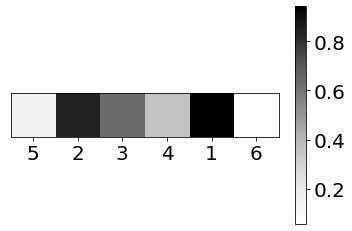

In [154]:
'''
# Forward pass. 
The goal of the forward pass is to identify the scores that belongs to top-k. 
The `soft_topk` object returns a smoothed indicator function: The entries are close to 1 for top-k scores, and close to 0 for non-top-k scores.
The smoothness is controled by hyper-parameter `epsilon`.
'''
A = soft_topk(scores_tensor)
indicator_vector = A.data.numpy()
print('======topk scores======')
print(indicator_vector[0,:])

plt.imshow(indicator_vector, cmap='Greys')
# plt.axis('off')
plt.yticks([])
plt.xticks(range(len(scores)), scores)
plt.colorbar()
plt.show()

In [155]:
'''
# Backward Pass

The goal of training is to push the scores that should have been top-k to really be top-k. 
For example, in neural kNN, we want to push the scores with the same labels as the query sample to be top-k.
In this demo, we mimick the loss function of neural kNN. 
`picked` is the scores ids with the same label as the query sample. Our training goal is to push them to be top-k.
'''

picked = [1,2,3]
loss = 0
for item in picked:
    loss += A[0,item]
loss.backward()
A_grad = scores_tensor.grad.clone()
print('======w.r.t score grad======')
print(A_grad.data.numpy())

======w.r.t score grad======
[[ 0.10541585 -0.04306151 -0.07465184 -0.07465144  0.04347444  0.04347456]]


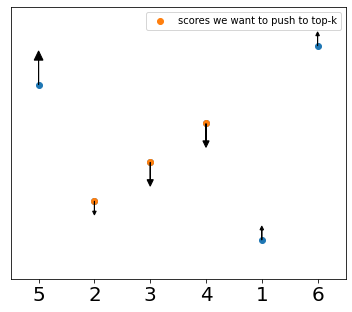

In [156]:
'''
# Visualization of the Grad
'''

x = scores
grad = A_grad.numpy()[0,:]
grad = grad/np.linalg.norm(grad)
plt.figure(figsize=(len(scores),5))
plt.scatter(range(len(x)), x)
picked_scores = [x[item] for item in picked]
plt.scatter(picked, picked_scores, label='scores we want to push to smallest top-k')
for i, item in enumerate(x):
    plt.arrow(i, item, 0, grad[i], head_width=abs(grad[i])/4, fc='k')
plt.xticks(range(len(x)), x)
plt.yticks([])
plt.xlim([-0.5, len(scores)-0.5])
plt.ylim([min(scores)-1, max(scores)+1])
plt.legend()
plt.show()

In [150]:
# clear the grad before rerun the forward-backward code
scores_tensor.grad.data.zero_()

tensor([[0., 0., 0., 0., 0., 0.]])